This file was created to turn our regression results back into classification. The method for turning regression back into classification was to use the cutoffs originally used on the TrueSkill scores in the training set, and to apply those cutoffs to the predicted TrueSkill scores to created predicted classes.

The notebook also has a couple of functions to compare models and visualize results. The model has functionality to print the grouind truth vs predicted TrueSkill score, and then overlay the regions of correct classification (see plot_class_sectors()). It also can print out the metrics (precison/recall/f1) of various models, which can be used to compare between models.

Relevant models are:

Current best model:
run using `python train.py --name transform_det_bos --label_type regr --l2 0 --gpu --data_path "/home/azureuser/cloudfiles/code/Users/gsv-ml-buildings-new/" --epochs 50 --upsample --cities detroit boston --transform piecewise_linear detroit`
the .pth file for this model can be found in the GSV folder, also linked here: https://drive.google.com/file/d/1l3A3hm_-I_WAvPUlTFvGhkDP6jfnQLJD/view?usp=sharing

Shubhang's (previous best) models
Run using either the lh or pa split (more info about those splits on the Github) as follows:
`python train.py --upsample --name det_best --label_type lh --l2 0 --gpu` or 
`python train.py --upsample --name det_best --label_type pa --l2 0 --gpu`

Author: Daniel Chen

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
#from matplotlib.pyplot import figure
#figure(figsize=(16, 12), dpi=800)


# This model can be created/trained by using this command:
# python train.py --name transform_det_bos --label_type regr --l2 0 --gpu --data_path "/home/azureuser/cloudfiles/code/Users/gsv-ml-buildings-new/" --epochs 50 --upsample --cities detroit boston --transform piecewise_linear detroit
# the .pth file for this model (our current best) can be found in the GSV folder, also linked here: https://drive.google.com/file/d/1l3A3hm_-I_WAvPUlTFvGhkDP6jfnQLJD/view?usp=sharing
base_cwd = "/home/azureuser/cloudfiles/code/Users/danschen/gsv-ml-buildings-new"
exp_name = "transform_det_bos"


## Write functions to read in the data

def get_dir_name(base_cwd, exp_name):
    #return(base_cwd + "/gsv-ml-buildings-new/exps/" + exp_name + "/")
    return(base_cwd + "/exps/" + exp_name + "/")

def load_gt_preds(base_cwd, exp_name):
    exp_dir = get_dir_name(base_cwd, exp_name)
    gt    = np.load(exp_dir+"gt.npy")
    preds = np.load(exp_dir+"preds.npy")
    imgs = np.load(exp_dir+"imgs.npy")
    return gt, preds, imgs



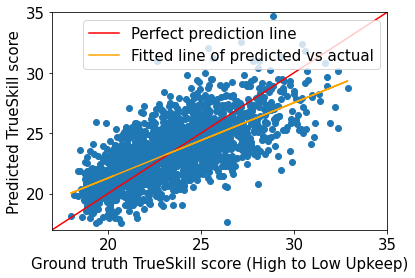

0.48425292923849006
4.4867024


In [2]:
# loading in the gt.npy and preds.npy file generated by eval.py
gt, preds, imgs = load_gt_preds(base_cwd, exp_name)

# plots results with x-axis as ground truth label, y-axis as predicted score, y=x perfect prediction line, and fitted line
plt.scatter(gt, preds)
plt.xlim(17, 35)
plt.ylim(17, 35)
plt.xlabel("Ground truth TrueSkill score (High to Low Upkeep)")
plt.ylabel("Predicted TrueSkill score")
plt.plot([0, 60], [0, 60], color="red", label="Perfect prediction line")
m, b = np.polyfit(gt, preds, 1)
plt.plot(gt, m*gt+b, color="orange", label="Fitted line of predicted vs actual")
plt.legend(loc='best')
plt.savefig('rn18_transformdetbos_largefont.png', facecolor='w', bbox_inches='tight')
plt.show()

# print R^2 and MSE
print((np.corrcoef(gt, preds)[0,1])**2)
print(((gt-preds)**2).mean())


In [3]:
# gets the cutoffs between class 0 and 1, 1 and 2, and 2 and 3
def get_cutoffs(df):
    df = df.sort_values(by="score", ascending=False).reset_index(drop=True)
    first_index = [df.where(df['trueskill_category']==i).first_valid_index() for i in range(4)]
    last_index  = [df.where(df['trueskill_category']==i).last_valid_index() for i in range(4)]
    cutoff_01 = (float(df.iloc[[last_index[0]]]['score']) + float(df.iloc[[first_index[1]]]['score']))/2
    cutoff_12 = (float(df.iloc[[last_index[1]]]['score']) + float(df.iloc[[first_index[2]]]['score']))/2
    cutoff_23 = (float(df.iloc[[last_index[2]]]['score']) + float(df.iloc[[first_index[3]]]['score']))/2
    print(first_index)
    print(last_index)
    cutoffs = [cutoff_01, cutoff_12, cutoff_23]
    return df, cutoffs

In [5]:
# getting cutoffs of the classes based on the training set's scores
train_loc = "/home/azureuser/cloudfiles/code/Users/gsv-ml-buildings-new/datasets/detroit/train.csv"
train = pd.read_csv(train_loc)

train, cutoffs_train = get_cutoffs(train)
cutoff_01, cutoff_12, cutoff_23 = cutoffs_train


print(cutoff_01, cutoff_12, cutoff_23)



[0, 307, 997, 3985]
[306, 996, 3984, 3994]
28.547064468438485 26.575636633239892 19.141102805188694


In [8]:
# turns trueskills score based on the thresholds 
def regr_to_classes(gt, cutoffs):
    if gt > cutoffs[0]:
        return 0
    if gt > cutoffs[1]:
        return 1
    if gt > cutoffs[2]:
        return 2
    return 3


val_loc = "/home/azureuser/cloudfiles/code/Users/gsv-ml-buildings-new/datasets/detroit/val.csv"
val = pd.read_csv(val_loc)
val, cutoffs_val = get_cutoffs(val)
print(cutoffs_val)
# turning the gt and pred TS scores to classes
gt_classes = [regr_to_classes(i, cutoffs_val) for i in gt]
pred_classes = [regr_to_classes(i, cutoffs_train) for i in preds]

print(len(gt_classes), len(pred_classes))

[0, 84, 241, 998]
[83, 240, 997, 999]
[28.557185937581863, 26.573061374600826, 19.053252291066272]
1741 1741


In [9]:
# get the classification results (precision/recall/f1) 
# for each class, a pa split and lh split (see details of split types in Github)
from sklearn import metrics

print(metrics.classification_report(gt_classes, pred_classes))
print('---------------------------')

pred_classes_pa = [0 if i==0 else 1 for i in pred_classes]
gt_classes_pa   = [0 if i==0 else 1 for i in gt_classes]
print(metrics.classification_report(gt_classes_pa, pred_classes_pa))
print('---------------------------')

pred_classes_lh = [0 if (i==0 or i==1) else 1 for i in pred_classes]
gt_classes_lh   = [0 if (i==0 or i==1) else 1 for i in gt_classes]
print(metrics.classification_report(gt_classes_lh, pred_classes_lh))
print('---------------------------')

              precision    recall  f1-score   support

           0       0.42      0.27      0.33        86
           1       0.25      0.22      0.23       164
           2       0.86      0.90      0.88      1416
           3       0.22      0.16      0.19        75

    accuracy                           0.77      1741
   macro avg       0.44      0.39      0.41      1741
weighted avg       0.75      0.77      0.76      1741

---------------------------
              precision    recall  f1-score   support

           0       0.42      0.27      0.33        86
           1       0.96      0.98      0.97      1655

    accuracy                           0.95      1741
   macro avg       0.69      0.62      0.65      1741
weighted avg       0.94      0.95      0.94      1741

---------------------------
              precision    recall  f1-score   support

           0       0.51      0.41      0.45       250
           1       0.90      0.93      0.92      1491

    accuracy      

In [10]:
# RESULTS FROM DETROIT ONLY - used to compare with Shubhang's model (which only validated on Detroit)   

det_gt_classes = gt_classes[:1000]
det_pred_classes = pred_classes[:1000]
print(metrics.classification_report(det_gt_classes, det_pred_classes))
print('---------------------------')

det_pred_classes_pa = [0 if i==0 else 1 for i in det_pred_classes]
det_gt_classes_pa   = [0 if i==0 else 1 for i in det_gt_classes]
print(metrics.classification_report(det_gt_classes_pa, det_pred_classes_pa))
print('---------------------------')

det_pred_classes_lh = [0 if (i==0 or i==1) else 1 for i in det_pred_classes]
det_gt_classes_lh   = [0 if (i==0 or i==1) else 1 for i in det_gt_classes]
print(metrics.classification_report(det_gt_classes_lh, det_pred_classes_lh))
print('---------------------------')

              precision    recall  f1-score   support

           0       0.43      0.27      0.33        84
           1       0.27      0.23      0.25       157
           2       0.83      0.88      0.85       757
           3       0.00      0.00      0.00         2

    accuracy                           0.73      1000
   macro avg       0.38      0.35      0.36      1000
weighted avg       0.70      0.72      0.71      1000

---------------------------
              precision    recall  f1-score   support

           0       0.43      0.27      0.33        84
           1       0.94      0.97      0.95       916

    accuracy                           0.91      1000
   macro avg       0.68      0.62      0.64      1000
weighted avg       0.89      0.91      0.90      1000

---------------------------
              precision    recall  f1-score   support

           0       0.54      0.42      0.48       241
           1       0.83      0.89      0.86       759

    accuracy      

In [11]:
# some experimentation to see if you can manually shift the regression line so it matches 1-to-1
# this is becuase when the gt vs pred model is fit it sometimes had a lower slope than 1
# not very promising
m, b = np.polyfit(gt, preds, 1)
print(m,b)

scaled_param = 0.5

preds_scaled = preds*scaled_param/m - b*scaled_param/m + (b-scaled_param*b)/(1-m)
pred_scaled_classes = [regr_to_classes(i, cutoffs_train) for i in preds_scaled]

print(metrics.classification_report(gt_classes, pred_scaled_classes))
print('---------------------------')

pred_scaled_classes_pa = [0 if i==0 else 1 for i in pred_scaled_classes]
gt_classes_pa   = [0 if i==0 else 1 for i in gt_classes]
print(metrics.classification_report(gt_classes_pa, pred_scaled_classes_pa))
print('---------------------------')

pred_scaled_classes_lh = [0 if (i==0 or i==1) else 1 for i in pred_scaled_classes]
gt_classes_lh   = [0 if (i==0 or i==1) else 1 for i in gt_classes]
print(metrics.classification_report(gt_classes_lh, pred_scaled_classes_lh))
print('---------------------------')

0.6238105484722535 8.807122843440258
              precision    recall  f1-score   support

           0       0.50      0.09      0.16        86
           1       0.27      0.16      0.20       164
           2       0.84      0.96      0.90      1416
           3       0.17      0.03      0.05        75

    accuracy                           0.80      1741
   macro avg       0.44      0.31      0.33      1741
weighted avg       0.74      0.80      0.76      1741

---------------------------
              precision    recall  f1-score   support

           0       0.50      0.09      0.16        86
           1       0.95      1.00      0.97      1655

    accuracy                           0.95      1741
   macro avg       0.73      0.54      0.57      1741
weighted avg       0.93      0.95      0.93      1741

---------------------------
              precision    recall  f1-score   support

           0       0.61      0.28      0.38       250
           1       0.89      0.97   

In [12]:
# designed to plot the class sectors, overlaying boxes on the previous gt vs pred boxes for classification regions
def plot_class_sectors(true, pred, cutoffs_x, cutoffs_y, fname=None):
    plt.scatter(true, pred, color="#005AB5")
    plt.xlim(17, 35)
    plt.ylim(17, 35)
    plt.xlabel("Ground truth TrueSkill score (High to Low Upkeep)")
    plt.ylabel("Predicted TrueSkill score")
    plt.plot([0, 60], [0, 60], color="#DC3220", label="Perfect prediction line")
    #m, b = np.polyfit(gt, preds, 1)
    #plt.plot(gt, m*gt+b, color="orange", label="Fitted line of predicted vs actual")
    plt.legend(loc='best')
    
    x_cuts = [0]
    x_cuts.extend(cutoffs_x)
    x_cuts.append(60)
    y_cuts = [0]
    y_cuts.extend(cutoffs_y)
    y_cuts.append(60)
    
    # drawing boxes
    for i in range(len(x_cuts)-1):
        x_list = np.arange(x_cuts[i], x_cuts[i+1], step=0.01)
        plt.fill_between(x_list, [y_cuts[i]]*len(x_list), [y_cuts[i+1]]*len(x_list), alpha=0.3, color="#DC3220")
        #print(x_list, [y_cuts[i]]*len(x_list), [y_cuts[i+1]]*len(x_list))
    if fname is not None:
        plt.savefig(fname, facecolor='w', bbox_inches='tight')

    plt.show()

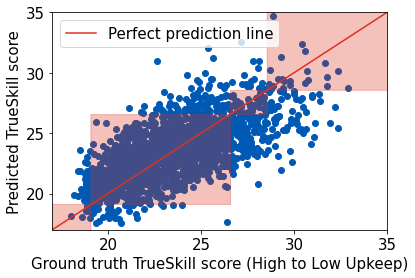

In [13]:
# note needing to reverse the cutoff values so its small to large. 
# Also note the validation set is used for the gt, while training set is used for predictions 
plot_class_sectors(gt, preds, cutoffs_val[::-1], cutoffs_train[::-1], fname='transform_bounds.png')

#plot_class_sectors(gt, preds, cutoffs_train[::-1], cutoffs_val[::-1])
#print(cutoffs_val[::-1], cutoffs_train[::-1])
#plot_class_sectors(gt, preds, [cutoffs_val[::-1][1]], [cutoffs_train[::-1][1]], fname='transform_bounds.png')

In [14]:
# train this model by running something like: python train.py --upsample --name det_best --label_type lh --l2 0 --gpu
old_lh_gt, old_lh_preds, _ = load_gt_preds("/home/azureuser/cloudfiles/code/Users/danschen/gsv-ml-buildings-new", "shubhang_lh")
# train this model by running something like: python train.py --upsample --name det_best --label_type pa --l2 0 --gpu
old_pa_gt, old_pa_preds, _ = load_gt_preds("/home/azureuser/cloudfiles/code/Users/danschen/gsv-ml-buildings-new", "shubhang_pa")

# print out the classification performance of the previous (Shubhang's work) model
print(metrics.classification_report(old_lh_gt, old_lh_preds))
print(metrics.classification_report(old_pa_gt, old_pa_preds))

              precision    recall  f1-score   support

           0       0.36      0.47      0.41       241
           1       0.81      0.73      0.77       759

    accuracy                           0.67      1000
   macro avg       0.59      0.60      0.59      1000
weighted avg       0.70      0.67      0.68      1000

              precision    recall  f1-score   support

           0       0.19      0.37      0.25        84
           1       0.94      0.85      0.89       916

    accuracy                           0.81      1000
   macro avg       0.56      0.61      0.57      1000
weighted avg       0.87      0.81      0.84      1000

